# **AN2DL First Challenge**
> ## ***Ibuprofen*** team

## 🌐 **Google Drive setup**

In [22]:
from google.colab import drive

drive.mount("/gdrive")
working_dir = "/gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/First Challenge"
input_dir = working_dir

%cd $working_dir

print(f"Working at folder: {working_dir}")
print(f"Input at folder: {input_dir}")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/First Challenge
Working at folder: /gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/First Challenge
Input at folder: /gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/First Challenge


## 🌐 **Kaggle setup**

In [ ]:
working_dir = "/kaggle/working"
input_dir = "/kaggle/input"

---
## ⚙️ **Libraries Import**

In [23]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os
from datetime import datetime

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.8.0+cu126
Device: cpu


---
## ⏳ **Data loading**

### Search for data in the working directory and load it

In [24]:
dataset_name = "an2dl2526c1"

dataset_dir = f"{input_dir}/{dataset_name}"

# Check if data directory exists
if not os.path.exists(dataset_dir):
    print(f"Error: Dataset folder not found for '{dataset_name}' at expected input path: {input_dir}")
# Load data
else:
  print(f"Dataset folder found for '{dataset_name}': {dataset_dir}")

  try:
      df_features_raw = pd.read_csv(f'{dataset_dir}/pirate_pain_train.csv')
      df_labels_raw = pd.read_csv(f'{dataset_dir}/pirate_pain_train_labels.csv')
      df_test_raw = pd.read_csv(f'{dataset_dir}/pirate_pain_test.csv')
  except FileNotFoundError as e:
        print(f"Error: CSV file {e.filename} not found at expected data path: {dataset_dir}")
  print(f"Dataset '{dataset_name}' loaded successfully")

Dataset folder found for 'an2dl2526c1': /gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/First Challenge/an2dl2526c1
Dataset 'an2dl2526c1' loaded successfully


## 🔎 **Data exploration and analysis**

### Inspect features at a glance

In [29]:
# Display the first few rows
print(f"Features shape: {df_features_raw.shape}")
print("Visual inspection of feature values:")
df_features_raw.head()

Features shape: (105760, 40)
Visual inspection of feature values:


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5


In [30]:
# Utility definitions
pain_survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
body_parts_cols = ['n_legs', 'n_hands', 'n_eyes']
joint_cols = [f'joint_{i:02d}' for i in range(31)] # joint_00 to joint_30


# Check missing values
num_features_any_null = df_features_raw.isnull().any(axis=1).sum()
print(f"\nFound {num_features_any_null} feature rows with null values")

# Check data types
feature_objects = df_features_raw.select_dtypes(include=['object']).columns.tolist()
print(f"\nFound {len(feature_objects)} object columns in features to be properly encoded: {feature_objects}")
for col in feature_objects:
    print(f"    Column '{col}': {df_features_raw[col].unique()}")

# Check static features (body_parts_cols) consistency per sample_index
body_parts_consistency = df_features_raw.groupby('sample_index')[body_parts_cols].nunique()
body_parts_inconsistencies = (body_parts_consistency != 1).any(axis=1).sum()
print(f"\nFound {body_parts_inconsistencies} inconsistencies in 'n_legs', 'n_hands' or 'n_eyes' static values")

# Display DataFrame info
print(f"\nFeatures shape: {df_features_raw.shape}")
print(f"\nFeatures inspection:")
df_features_raw.info()


Found 0 feature rows with null values

Found 3 object columns in features to be properly encoded: ['n_legs', 'n_hands', 'n_eyes']
    Column 'n_legs': ['two' 'one+peg_leg']
    Column 'n_hands': ['two' 'one+hook_hand']
    Column 'n_eyes': ['two' 'one+eye_patch']

Found 0 inconsistencies in 'n_legs', 'n_hands' or 'n_eyes' static values

Features shape: (105760, 40)

Features inspection:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9 

### Inspect labels at a glance

In [27]:
# Display the first few rows
print(f"Labels shape: {df_labels_raw.shape}")
print("Visual inspection of label values:")
df_labels_raw.head()

Labels shape: (661, 2)
Visual inspection of label values:


,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,low_pain
3,3,no_pain
4,4,no_pain


In [28]:
# Check missing values
num_labels_any_null = df_labels_raw.isnull().any(axis=1).sum()
print(f"\nFound {num_labels_any_null} feature rows with null values")

# Check data types
label_objects = df_labels_raw.select_dtypes(include=['object']).columns.tolist()
print(f"\nFound object columns in labels to be properly encoded: {label_objects}")
for col in label_objects:
    print(f"   Column '{col}': {df_labels_raw[col].unique()}")

# Display DataFrame info
print(f"\nLabels shape: {df_labels_raw.shape}")
print(f"\nLabels inspection:")
df_labels_raw.info()


Found 0 feature rows with null values

Found object columns in labels to be properly encoded: ['label']
   Column 'label': ['no_pain' 'low_pain' 'high_pain']

Labels shape: (661, 2)

Labels inspection:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661 entries, 0 to 660
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sample_index  661 non-null    int64 
 1   label         661 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.5+ KB


### Drop missing values

In [31]:
# Remove rows with any missing values
df_features_raw.dropna(axis=0, how='any', inplace=True)
df_labels_raw.dropna(axis=0, how='any', inplace=True)
print("\nMissing values removed from features and labels")


Missing values removed from features and labels


### Merge features and labels

In [32]:
# Print the number of unique samples in features
num_unique_features_samples = df_features_raw['sample_index'].nunique()
print(f"\nFound {num_unique_features_samples} unique samples in features")

# Print the number of unique samples in labels
num_unique_labels_samples = df_labels_raw['sample_index'].nunique()
print(f"\nFound {num_unique_labels_samples} unique samples in features")

# Verify that in labels each sample appears one time only
labels_sample_counts = df_labels_raw['sample_index'].value_counts()
if (labels_sample_counts == 1).all():
    print("\nEach sample is involved in ONE experiment only")
else:
    print("\nSamples may be involved in MULTIPLE experiments")


# Merge (left join) features and labels by sample_index
df_features_x_labels = pd.merge(df_features_raw, df_labels_raw, on='sample_index', how='left')
print(f"\nFeatures-X-Labels shape: {df_features_x_labels.shape}")
print(f"    Features shape: {df_features_raw.shape}")
print(f"    Labels shape: {df_labels_raw.shape}")

print(f"\nFeatures-X-Labels inspection:")
df_features_x_labels.head()


Found 661 unique samples in features

Found 661 unique samples in features

Each sample is involved in ONE experiment only

Features-X-Labels shape: (105760, 41)
    Features shape: (105760, 40)
    Labels shape: (661, 2)

Features-X-Labels inspection:


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,0,0,2,0,2,1,two,two,two,1.094705,...,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5,no_pain
1,0,1,2,2,2,2,two,two,two,1.135183,...,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5,no_pain
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5,no_pain
3,0,3,2,2,2,2,two,two,two,0.938017,...,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5,no_pain
4,0,4,2,2,2,2,two,two,two,1.090185,...,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5,no_pain


### Check number of time steps per sample
  > Each `samples_index` has been tracked for the same number of `time` steps: this simplifies sequence management.


Total number of samples: 661

Distribution of time steps per sample:
160    661
Name: count, dtype: int64

Saved time steps distribution plot to: 'time_steps_distribution.png'.


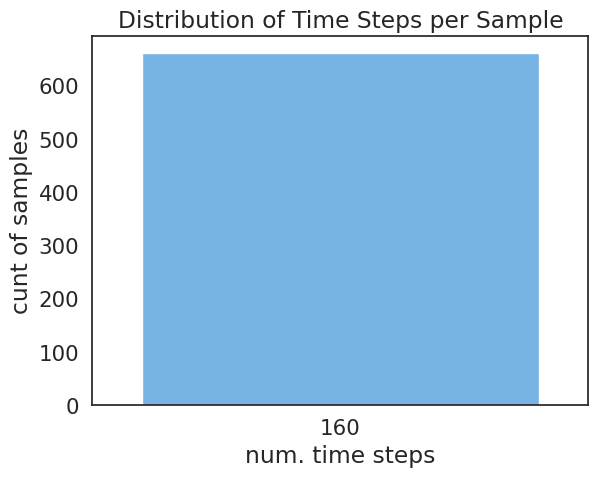

In [33]:
# Group by sample_index and take the number of rows per group (i.e., per sample)
time_steps_per_sample = df_features_x_labels.groupby('sample_index').size()

# Print total number of sample_index
print(f"\nTotal number of samples: {time_steps_per_sample.size}")

# Get the distribution of these sizes
time_step_distribution = time_steps_per_sample.value_counts()
print(f"\nDistribution of time steps per sample:\n{time_step_distribution}")

ax = sns.barplot(
    x=time_step_distribution.index,
    y=time_step_distribution.values,
    palette=["#64B5F6"]
)

plt.title('Distribution of Time Steps per Sample')
plt.xlabel('num. time steps')
plt.ylabel('cunt of samples')
plt.savefig("time_steps_distribution.png")
print("\nSaved time steps distribution plot to: 'time_steps_distribution.png'.")

### Check target labels distribution
  > It seems labels are not evenly-distributed: this has to be taken into account when splitting the training dataset into train set and validation set.


Distribution of labels:
label
no_pain      511
low_pain      94
high_pain     56
Name: count, dtype: int64

Saved label distribution plot to: 'label_distribution.png'


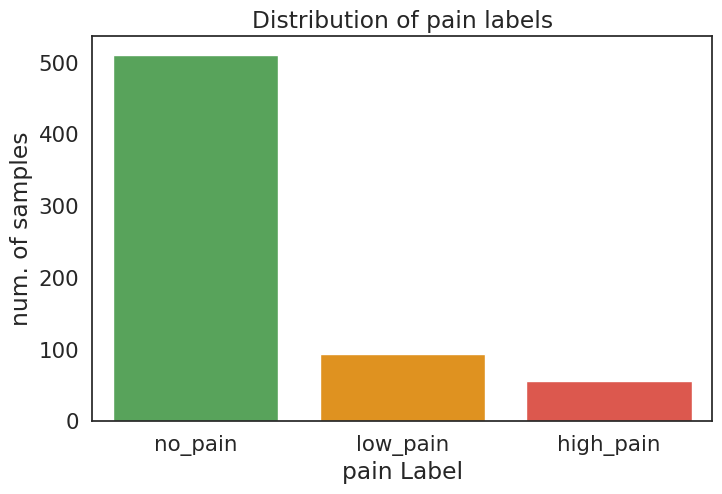

In [34]:
# Configure good-looking palette and order for pain :)
pain_plt_palette = {
    'no_pain': '#4CAF50',
    'low_pain': '#FF9800',
    'high_pain': '#F44336'
}
pain_plt_order = ['no_pain', 'low_pain', 'high_pain']

# Group labels and count sizes
print(f"\nDistribution of labels:")
label_counts = df_labels_raw['label'].value_counts()
print(label_counts)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    order=pain_plt_order,
    palette=pain_plt_palette
)
plt.title('Distribution of pain labels')
plt.xlabel('pain Label')
plt.ylabel('num. of samples')
plt.savefig("label_distribution.png")
print("\nSaved label distribution plot to: 'label_distribution.png'")

### Descriptive statistics: numeric features

Summary

In [35]:
# Define numeric features
numeric_cols = joint_cols

# Display summary for numeric features
print("\nDescriptive statistics summary (numeric features):")
numeric_stats = df_features_x_labels[numeric_cols].describe()
display(numeric_stats)


Descriptive statistics summary (numeric features):


,joint_00,joint_01,joint_02,joint_03,joint_04,joint_05,joint_06,joint_07,joint_08,joint_09,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
count,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,...,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,105760.000000,105760.000000,105760.000000,105760.000000,105760.0
mean,0.943095,0.916955,0.779296,0.767921,0.709186,0.711306,0.875185,0.837427,0.849700,0.909554,...,3.972126e-05,4.176794e-05,3.561780e-05,3.138109e-05,1.024604e-04,0.041905,0.058244,0.049886,0.062273,0.5
std,0.202051,0.197608,0.295605,0.300787,0.418058,0.411783,0.240900,0.237904,0.180489,0.180320,...,4.974496e-03,5.472244e-03,1.235450e-03,4.062914e-04,3.206128e-03,0.060293,0.079819,0.060773,0.072597,0.0
min,0.000000,0.000000,0.001015,0.005403,0.000000,0.000000,0.000000,0.000000,0.122095,0.004671,...,0.000000e+00,1.510494e-07,0.000000e+00,1.063144e-08,0.000000e+00,0.000203,0.000000,0.000000,0.000000,0.5
25%,0.828277,0.811445,0.568850,0.520020,0.184585,0.210551,0.839166,0.781375,0.717725,0.825898,...,6.545878e-08,3.321650e-07,3.275038e-07,2.841805e-07,7.161332e-07,0.009885,0.012652,0.016290,0.019638,0.5
50%,1.005126,0.979468,0.909549,0.914834,0.930007,0.950628,0.937363,0.904914,0.831221,0.940954,...,8.302747e-07,1.095971e-06,1.024209e-06,8.746147e-07,3.126723e-06,0.021898,0.031739,0.031843,0.039041,0.5
75%,1.081039,1.056611,0.995187,0.994324,1.036497,1.032400,1.013150,0.984410,0.991104,1.030941,...,2.800090e-06,3.079465e-06,3.021830e-06,2.507548e-06,9.946107e-06,0.048579,0.071051,0.058741,0.079518,0.5
max,1.407968,1.334613,1.306046,1.254729,1.359204,1.387731,1.410532,1.361969,1.357288,1.388105,...,1.442198e+00,1.305001e+00,2.742411e-01,3.643074e-02,9.473540e-01,1.223617,1.187419,1.412037,1.370765,0.5


Check constant features
  > It seems the `joint_30` feature is constant: it could be dropped in data preprocessing.

In [36]:
# Check for constant numeric features
constant_numeric_cols = numeric_stats.columns[numeric_stats.loc["std"] == 0].tolist()

if len(constant_numeric_cols) > 0:
  print(f"\nFound {len(constant_numeric_cols)} constant numeric features with 0 variance: {constant_numeric_cols}")
  print("These features provide no information and should be dropped")
  for col in constant_numeric_cols:
    print(f"    Column '{col}': {df_features_x_labels[col].unique()}")
else:
  print("\nNo constant numeric feature found")


Found 1 constant numeric features with 0 variance: ['joint_30']
These features provide no information and should be dropped
    Column 'joint_30': [0.5]


Check order of magnitude of features' max and min
  > Joint features may differ a lot both in terms of scales of maximum and minimum, and range size: this reinforces the need to normalize each feature based on its maximum and minimum values.


Saved plot of log10 of joint max and min values to: 'joint_max_min_log10.png'


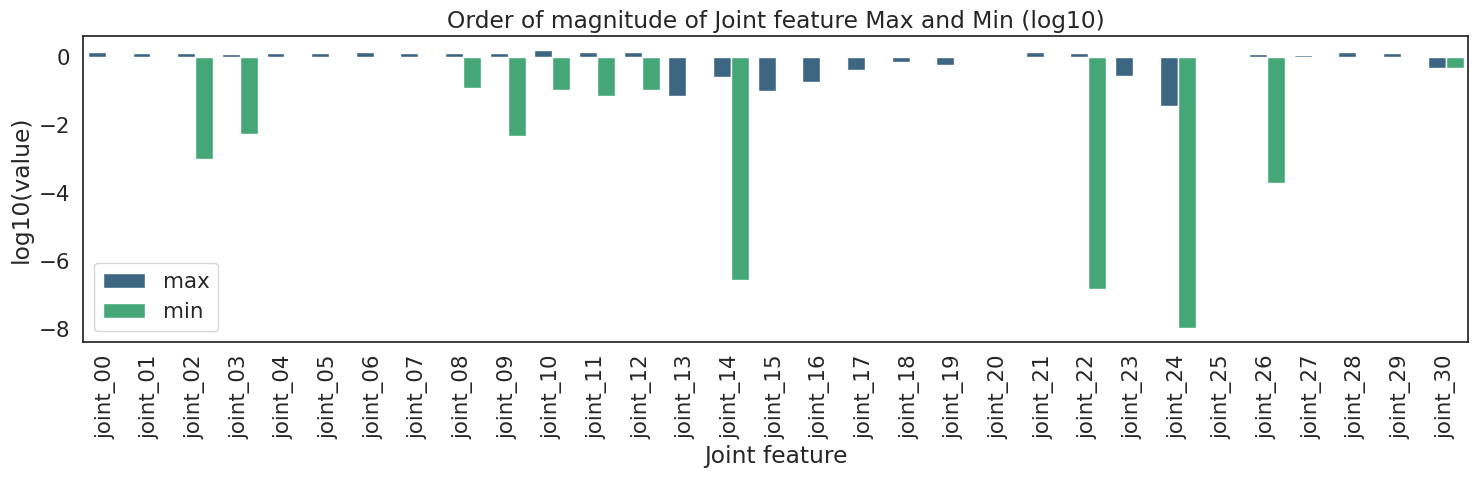

In [37]:
# Compute the base-10 logarithm of the absolute maximum and minimum values
numeric_cols_max_log10 = np.log10(np.abs(numeric_stats.loc["max"]))
numeric_cols_min_log10 = np.log10(np.abs(numeric_stats.loc["min"]))

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Feature': numeric_cols_max_log10.index.tolist() + numeric_cols_min_log10.index.tolist(),
    'Order of Magnitude (log10)': numeric_cols_max_log10.values.tolist() + numeric_cols_min_log10.values.tolist(),
    'Type': ['max'] * len(numeric_cols_max_log10) + ['min'] * len(numeric_cols_min_log10)
})

# Display
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='Feature', y='Order of Magnitude (log10)', hue='Type', data=plot_data, palette="viridis")
plt.xticks(rotation=90)
plt.title('Order of magnitude of Joint feature Max and Min (log10)')
plt.xlabel('Joint feature')
plt.ylabel('log10(value)')
plt.tight_layout()
plt.savefig("joint_max_min_log10.png")
print("\nSaved plot of log10 of joint max and min values to: 'joint_max_min_log10.png'")

# Remove the legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title=None)

plt.show()

### Descriptive statistics: categorical features

Summary


Descriptive statistics summary (categorical features)


,pain_survey_1,count,pain_survey_2,count,pain_survey_3,count,pain_survey_4,count
0,0,12352,0,11760,0,11529,0,11361
1,1,14031,1,12983,1,13573,1,12905
2,2,79377,2,81017,2,80658,2,81494



Saved pain_survey_distributions.png plot to: 'pain_survey_distributions.png'


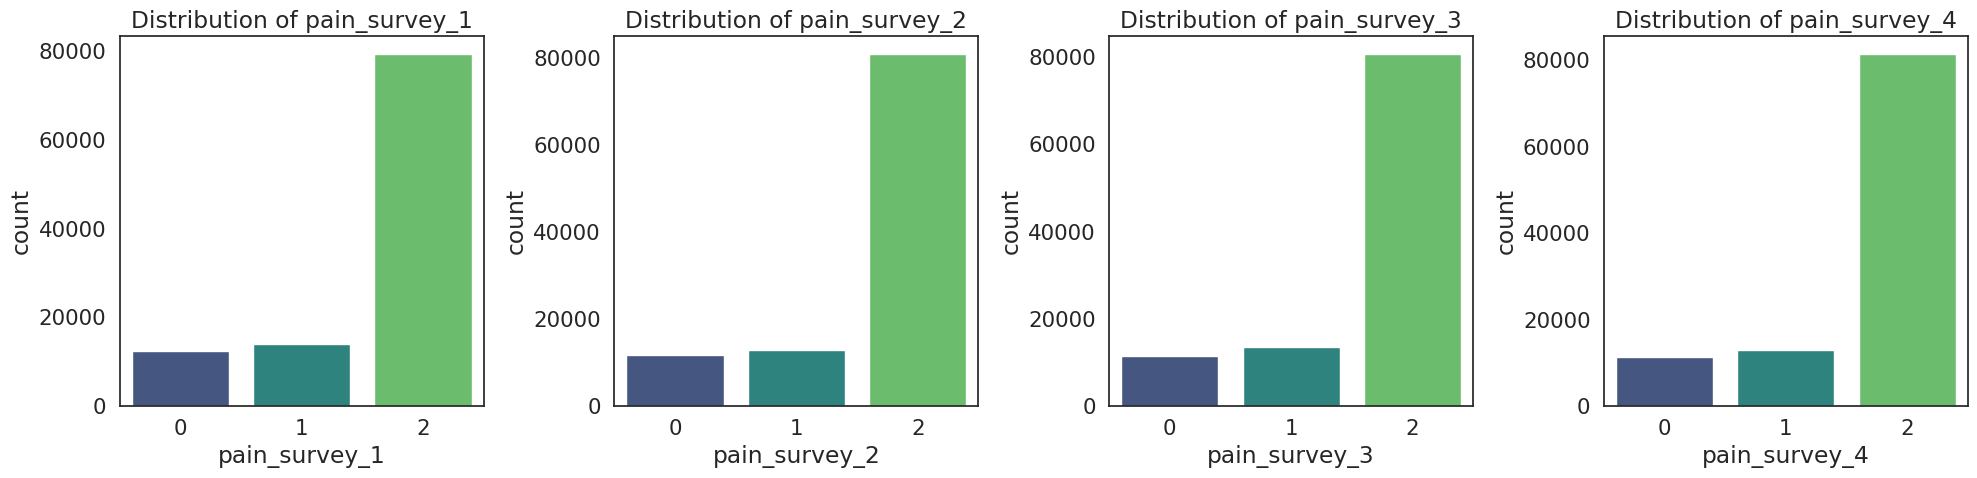

,n_legs,count,n_hands,count,n_eyes,count
0,one+peg_leg,6,one+hook_hand,6,one+eye_patch,6
1,two,655,two,655,two,655



Saved body_parts_distributions.png plot to: 'body_parts_distributions.png'


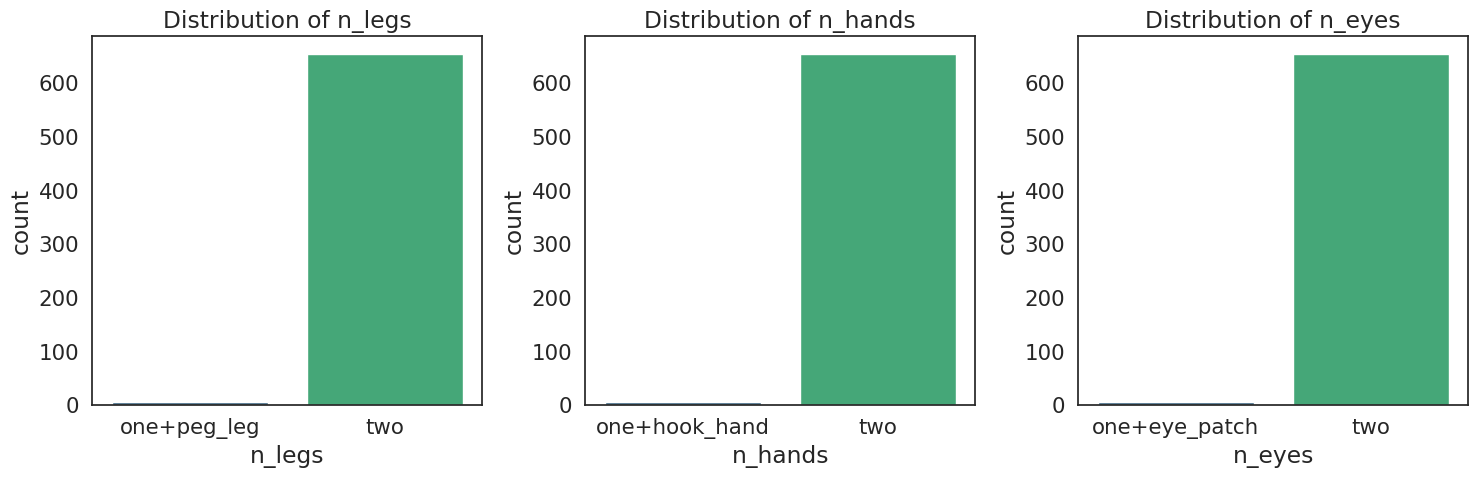

In [45]:
def plot_categorical_distributions(df, cols, palette, filename):
    """Plots count distributions for a list of categorical columns and prints frequencies."""
    n_cols = len(cols)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))

    # Ensure axes is an array even if there's only one column
    if n_cols == 1:
        axes = [axes]

    freq_dfs = []
    for i, col in enumerate(cols):
        # Prepare frequencies to be displayed
        freq_df = df[col].value_counts().sort_index().reset_index()
        freq_df.columns = [col, 'count']
        freq_dfs.append(freq_df)

        # Plot distributions
        sns.countplot(
            x=col,
            data=df,
            palette=palette,
            order=df[col].value_counts().sort_index().index,
            ax=axes[i]
        )
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('count')

    # Display frequencies side by side
    display(pd.concat(freq_dfs, axis=1))

    plt.tight_layout()
    plt.savefig(filename)
    print(f"\nSaved {filename} plot to: '{filename}'")
    plt.show()

# Display summary for categorical features
print("\nDescriptive statistics summary (categorical features)")
plot_categorical_distributions(df_features_x_labels, pain_survey_cols, "viridis", "pain_survey_distributions.png")

plot_categorical_distributions(df_features_x_labels.groupby('sample_index')[body_parts_cols].head(1), body_parts_cols, "viridis", "body_parts_distributions.png")

Check constant features

In [17]:
constant_categorical_cols = df_features_x_labels[pain_survey_cols + body_parts_cols].nunique()
constant_categorical_cols = constant_categorical_cols[constant_categorical_cols == 1].index.tolist()

if len(constant_categorical_cols) > 0:
  print(f"\nFound {len(constant_categorical_cols)} constant categorical features: {constant_categorical_cols}")
  print("These features provide no information and should be dropped")
  for col in constant_categorical_cols:
    print(f"    Column '{col}': {df_features_x_labels[col].unique()}")
else:
  print("\nNo constant categorical feature found")


No constant categorical feature found


Correlation between missing body parts
  > It seems if one is missing, all are missing: they could be preprocessed into one single feature.


Body parts features combinations count:


,,,count
n_legs,n_hands,n_eyes,
two,two,two,104800
one+peg_leg,one+hook_hand,one+eye_patch,960



Saved body parts correlation matrix plot to: 'body_parts_correlation_matrix.png'


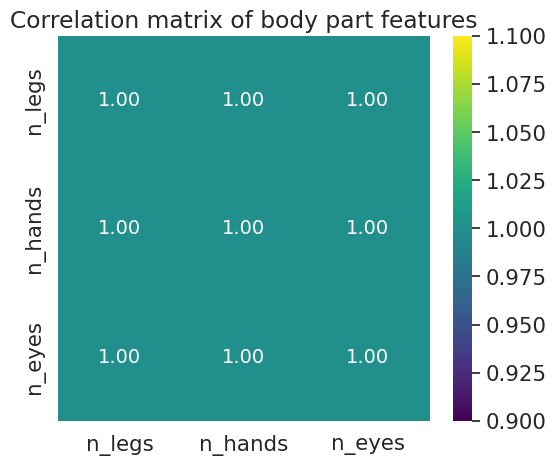

In [18]:
# Check the combinations of body parts features
print("\nBody parts features combinations count:")
display(df_features_x_labels[body_parts_cols].value_counts())

# Encode body part features into numbers
body_parts_encoded = df_features_x_labels.groupby('sample_index')[body_parts_cols].head(1).copy()
body_parts_encoded['n_legs'] = body_parts_encoded['n_legs'].apply(lambda x: 1 if x == 'one+peg_leg' else 0)
body_parts_encoded['n_hands'] = body_parts_encoded['n_hands'].apply(lambda x: 1 if x == 'one+hook_hand' else 0)
body_parts_encoded['n_eyes'] = body_parts_encoded['n_eyes'].apply(lambda x: 1 if x == 'one+eye_patch' else 0)

# Compute the correlation matrix
body_parts_correlation_matrix = body_parts_encoded.corr()

# Display the correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(body_parts_correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation matrix of body part features')
plt.savefig("body_parts_correlation_matrix.png")
print("\nSaved body parts correlation matrix plot to: 'body_parts_correlation_matrix.png'")
plt.show()

Spearman' correlation of body parts (static) features against pain labels
  > Spearman's correlation assesses monotonic relationships (`no_pain` < `low_pain` <
  `high_pain`). </br>
  It seems body parts features have almost no correlation with pain: probably, they could be totally dropped. </br>
  Afterall, pirates are humans...

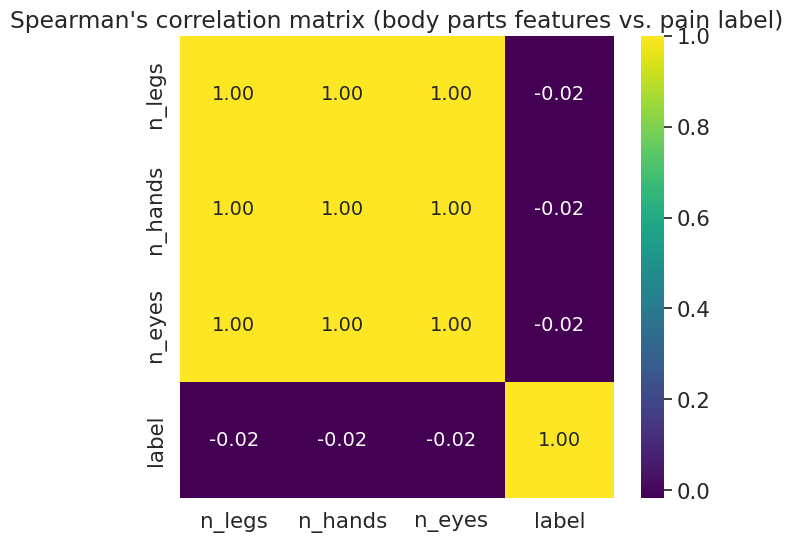


Body parts features Spearman's correlation against label:


,label
n_legs,-0.016866
n_hands,-0.016866
n_eyes,-0.016866


In [19]:
# Create the monotonic encoding for the label
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# Build the Spearman's correlation matrix
bp_x_labels_encoded = df_features_x_labels.groupby('sample_index')[[*body_parts_cols, 'label']].head(1).copy()
bp_x_labels_encoded['n_legs'] = bp_x_labels_encoded['n_legs'].apply(lambda x: 1 if x == 'one+peg_leg' else 0)
bp_x_labels_encoded['n_hands'] = bp_x_labels_encoded['n_hands'].apply(lambda x: 1 if x == 'one+hook_hand' else 0)
bp_x_labels_encoded['n_eyes'] = bp_x_labels_encoded['n_eyes'].apply(lambda x: 1 if x == 'one+eye_patch' else 0)
bp_x_labels_encoded['label'] = bp_x_labels_encoded['label'].map(label_mapping)
bp_x_labels_spearman_corr_matrix = bp_x_labels_encoded.corr(method='spearman')

# Display the heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(bp_x_labels_spearman_corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title("Spearman's correlation matrix (body parts features vs. pain label)")
plt.show()

# Display the specific correlations
print("\nBody parts features Spearman's correlation against label:")
# Drop the label's correlation with itself
bp_spearman_corr_vs_labels = bp_x_labels_spearman_corr_matrix['label'].drop('label')
display(bp_spearman_corr_vs_labels)

---
## 🔄 **Data preprocessing**

In [20]:
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}
pain_survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
body_parts_cols = ['n_legs', 'n_hands', 'n_eyes']
joint_cols = [f'joint_{i:02d}' for i in range(30)] # joint_00 to joint_29

df_features = df_features_raw.copy()
df_labels = df_labels_raw.copy()
df_labels['label'] = df_labels_raw['label'].map(label_mapping)

df_test = df_test_raw.copy()

df_features[joint_cols] = df_features[joint_cols].astype(np.float32)
df_test[joint_cols] = df_test[joint_cols].astype(np.float32)

df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float32
 10  joint_01       105760 non-null  float32
 11  joint_02       105760 non-null  float32
 12  joint_03       105760 non-null  float32
 13  joint_04       105760 non-null  float32
 14  joint_05       105760 non-null  float32
 15  joint_06       105760 non-null  float32
 16  joint_07       105760 non-null  float32
 17  joint_08       105760 non-nul

### Feature selection - Drop constant features: `joint_30`

In [21]:
df_features.drop(columns=['joint_30'], inplace=True, errors='ignore')
df_test.drop(columns=['joint_30'], inplace=True, errors='ignore')

df_features.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_20,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29
0,0,0,2,0,2,1,two,two,two,1.094705,...,6.140248e-07,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815
1,0,1,2,2,2,2,two,two,two,1.135183,...,1.931978e-06,3.976952e-07,6.765108e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716
2,0,2,2,0,2,2,two,two,two,1.080745,...,5.730838e-07,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105
3,0,3,2,2,2,2,two,two,two,0.938017,...,3.677486e-05,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648
4,0,4,2,2,2,2,two,two,two,1.090185,...,2.037939e-05,4.437265e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328


### Feature selection - Drop static features uncorrelated with labels: `n_legs`, `n_hands` and `n_eyes`

In [22]:
df_features.drop(columns=body_parts_cols, inplace=True, errors='ignore')
df_test.drop(columns=body_parts_cols, inplace=True, errors='ignore')

df_features.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_20,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29
0,0,0,2,0,2,1,1.094705,0.985281,1.018302,1.010385,...,6.140248e-07,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815
1,0,1,2,2,2,2,1.135183,1.021175,0.994343,1.052364,...,1.931978e-06,3.976952e-07,6.765108e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716
2,0,2,2,0,2,2,1.080745,0.962842,1.009588,0.977169,...,5.730838e-07,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105
3,0,3,2,2,2,2,0.938017,1.081592,0.998021,0.987283,...,3.677486e-05,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648
4,0,4,2,2,2,2,1.090185,1.032145,1.008710,0.963658,...,2.037939e-05,4.437265e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328


### Feature selection - One-hot encode categorical features: `pain_survey_1`, `pain_survey_2`, `pain_survey_3`, `pain_survey_4`

In [23]:
# One-hot encode pain_survey columns and replace them in df_features
df_features = pd.get_dummies(
    df_features,
    columns=pain_survey_cols,
    prefix=pain_survey_cols,
    dtype=float # Use float dtype for consistency
)
df_test = pd.get_dummies(
    df_test,
    columns=pain_survey_cols,
    prefix=pain_survey_cols,
    dtype=float # Use float dtype for consistency
)

pain_survey_ohenceded_cols = [col for col in df_features.columns if col.startswith('pain_survey_')]

display(df_features[['sample_index', 'time', *pain_survey_ohenceded_cols]].head())

,sample_index,time,pain_survey_1_0,pain_survey_1_1,pain_survey_1_2,pain_survey_2_0,pain_survey_2_1,pain_survey_2_2,pain_survey_3_0,pain_survey_3_1,pain_survey_3_2,pain_survey_4_0,pain_survey_4_1,pain_survey_4_2
0,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0,3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


### Data preparation functions

In [24]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [25]:
# Define a function to build sequences from the dataset
def build_sequences(df_features, df_labels=None, window=200, stride=200):
    """
    Builds sequences from time series data using a sliding window approach.

    Args:
        df_features (pd.DataFrame): DataFrame with time series features.
                                    Must contain 'sample_index' and 'time' columns,
                                    and the features specified in pain_survey_ohenceded_cols and joint_cols.
        df_labels (pd.DataFrame, optional): DataFrame with labels.
                                           Must contain 'sample_index' and 'label' columns.
                                           Defaults to None.
        window (int): The size of the sliding window.
        stride (int): The step size for the sliding window.

    Returns:
        tuple: (dataset, labels, sample_indices) - Numpy arrays of sequences,
               corresponding labels (if df_labels is provided), and original sample indices
               for each sequence.
    """
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0, "Window must be divisible by stride"

    # Initialise lists to store sequences, their corresponding labels, and original sample indices
    temporal_cols = pain_survey_ohenceded_cols + joint_cols
    dataset = []
    labels = []
    sequence_sample_indices = [] # Store the original sample index for each sequence

    # Iterate over unique IDs in the DataFrame
    sample_indices = df_features['sample_index'].unique()
    for id in sample_indices:
        # Extract data for the current ID
        temp_df = df_features[df_features['sample_index'] == id].copy() # Use copy to avoid SettingWithCopyWarning
        temp = temp_df[temporal_cols].values


        # Retrieve the pain label for the current ID
        if df_labels is not None:
          label = df_labels[df_labels['sample_index'] == id]['label'].values[0]

        # Calculate padding length to ensure full windows
        # This padding is needed to ensure the last window captures the end of the sequence
        padding_len = window - len(temp) % window
        if padding_len > 0 and padding_len != window: # Avoid adding full window of padding if sequence length is already a multiple of window
             padding = np.zeros((padding_len, len(temporal_cols)), dtype='float32')
             temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels and sample index
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            if df_labels is not None:
              labels.append(label)
            sequence_sample_indices.append(id) # Append the original sample index
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    labels = np.array(labels)
    sequence_sample_indices = np.array(sequence_sample_indices)

    if df_labels is not None:
        return dataset, labels, sequence_sample_indices
    else:
        return dataset, sequence_sample_indices # Return only dataset and sample indices for test data

---
## 🛠️ **Model building** functions

In [26]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [27]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits

## 🧠 **Model training** functions

In [28]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0, max_grad_norm=1.0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization
        max_grad_norm (float): max gradient for gradient clipping

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            inputs = inputs.to(torch.float32)
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        # Unscale the gradients, then clip them
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        # Apply gradients and update weights
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [29]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                inputs = inputs.to(torch.float32)
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [30]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [31]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

---
## 🔀 **K-Shuffle-Split Cross Validation** functions

In [32]:
def k_shuffle_split_cross_validation_round_rnn(df, df_labels, epochs, criterion, device,
                            k, test_size, batch_size, hidden_layers, hidden_size, learning_rate, dropout_rate,
                            window_size, stride, rnn_type, bidirectional,
                            l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name=""):
    """
    Perform K-fold shuffle split cross-validation with user-based splitting for time series data.

    Args:
        df: DataFrame with columns ['sample_index', 'time', *pain_survey_ohenceded_cols, *joint_cols]
        df_labels: DataFrame with columns ['label']
        epochs: Number of training epochs
        criterion: Loss function
        device: torch.device for computation
        k: Number of cross-validation splits
        test_size: Number of users or fraction of users for validation set
        batch_size: Batch size for training
        hidden_layers: Number of recurrent layers
        hidden_size: Hidden state dimensionality
        learning_rate: Learning rate for optimizer
        dropout_rate: Dropout rate
        window_size: Length of sliding windows
        stride: Step size for sliding windows
        rnn_type: Type of RNN ('RNN', 'LSTM', 'GRU')
        bidirectional: Whether to use bidirectional RNN
        l1_lambda: L1 regularization coefficient (if used)
        l2_lambda: L2 regularization coefficient (weight_decay)
        patience: Early stopping patience
        evaluation_metric: Metric to monitor for early stopping
        mode: 'max' or 'min' for evaluation metric
        restore_best_weights: Whether to restore best weights after training
        writer: TensorBoard writer
        verbose: Verbosity level
        seed: Random seed
        experiment_name: Name for experiment logging

    Returns:
        fold_losses: Dict with validation losses for each split
        fold_metrics: Dict with validation F1 scores for each split
        best_scores: Dict with best F1 score for each split plus mean and std
        best_model: Best model among the K-Shuffle-Splits
        best_experiment_name: Experiment name of the best model
    """

    # Initialize best model tracking variables
    best_model = None
    best_experiment_name = None
    best_performance = float('-inf')

    # Initialise containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    # Get model architecture parameters
    in_features = len(pain_survey_ohenceded_cols) + len(joint_cols)
    num_classes = len(df_labels['label'].unique())

    # Initialise model architecture
    model = RecurrentClassifier(
        input_size=in_features,
        hidden_size=hidden_size,
        num_layers=hidden_layers,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        bidirectional=bidirectional,
        rnn_type=rnn_type
    ).to(device)

    # Store initial weights to reset model for each split
    initial_state = copy.deepcopy(model.state_dict())

    # Iterate through K random splits
    for split_idx in range(k):

        if verbose > 0:
            print(f"Split {split_idx+1}/{k}")

        # Randomly split sample_indices for training and validation
        train_users, val_users, train_labels, val_labels = train_test_split(
            df_labels['sample_index'], df_labels['label'],
            test_size=test_size,
            random_state=SEED+split_idx, # enforce randomness for each split
            stratify=df_labels['label'] # stratify by pain labels frequency
        )

        # Split the dataset into training and validation sets based on sample indices
        df_train = df[df['sample_index'].isin(train_users)].copy()
        df_val = df[df['sample_index'].isin(val_users)].copy()
        df_train_labels = df_labels[df_labels['sample_index'].isin(train_users)].copy()
        df_val_labels = df_labels[df_labels['sample_index'].isin(val_users)].copy()

        if verbose > 0:
            print(f"  Training set shape: {df_train.shape}")
            print(f"  Validation set shape: {df_val.shape}")

        # Normalise features using training set statistics
        train_max = df_train[joint_cols].max()
        train_min = df_train[joint_cols].min()
        df_train[joint_cols] = (df_train[joint_cols] - train_min) / (train_max - train_min + 1e-8)
        df_val[joint_cols] = (df_val[joint_cols] - train_min) / (train_max - train_min + 1e-8)

        # Build sequences using the existing build_sequences function
        X_train, y_train, _ = build_sequences(df_train, df_train_labels, window=window_size, stride=stride)
        X_val, y_val, _ = build_sequences(df_val, df_val_labels, window=window_size, stride=stride)

        if verbose > 0:
            print(f"  Training sequences shape: {X_train.shape}")
            print(f"  Validation sequences shape: {X_val.shape}")

        # Create PyTorch datasets
        train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
        val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

        # Create data loaders
        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader   = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # Reset model to initial weights for fair comparison across splits
        model.load_state_dict(initial_state)

        # Define optimizer with L2 regularization
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training for GPU acceleration
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)
        # Hierarchical experiment name
        split_experiment_name = f"{experiment_name}/split_{split_idx}"

        # Train model on current split
        model, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=split_experiment_name
        )

        # Store results for this split
        fold_losses[f"split_{split_idx}"] = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history['val_f1']
        best_scores[f"split_{split_idx}"] = max(training_history['val_f1'])

        # Update best model if current performance is superior
        if best_scores[f"split_{split_idx}"] > best_performance:
            best_model = model
            best_experiment_name = split_experiment_name
            best_performance = best_scores[f"split_{split_idx}"]

    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])

    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}±{best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores, best_model, best_experiment_name

---
##  🎛️ **Hyperparameter tuning** functions

In [33]:
def grid_search_cv_rnn(df, df_labels, param_grid, fixed_params, cv_params, verbose=True):
    """
    Execute grid search with K-shuffle-split cross-validation for RNN models on time series data.

    Args:
        df: DataFrame with columns ['sample_index', *pain_survey_ohenceded_cols, *joint_cols]
        param_grid: Dict of parameters to test, e.g. {'batch_size': [16, 32], 'rnn_type': ['LSTM', 'GRU']}
        fixed_params: Dict of fixed hyperparameters (hidden_size, learning_rate, window_size, stride, etc.)
        cv_params: Dict of CV settings (epochs, k, patience, criterion, scaler, device, etc.)
        verbose: Print progress for each configuration

    Returns:
        results: Dict with scores for each configuration
        best_config: Dict with best hyperparameter combination
        best_score: Best mean F1 score achieved
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None

    total = len(combinations)

    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

        if verbose:
            print(f"\nConfiguration {idx}/{total}:")
            for param, value in current_config.items():
                print(f"  {param}: {value}")

        # Merge current config with fixed parameters
        run_params = {**fixed_params, **current_config}

        # Execute cross-validation
        _, _, fold_scores = k_shuffle_split_cross_validation_round_rnn(
            df=df,
            df_labels=df_labels,
            experiment_name=config_str,
            **run_params,
            **cv_params
        )

        # Store results
        results[config_str] = fold_scores

        # Track best configuration
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            if verbose:
                print("🎉🎉🎉  NEW BEST SCORE!  🎉🎉🎉")

        if verbose:
            print(f"  F1 Score: {fold_scores['mean']:.4f}±{fold_scores['std']:.4f}")

    return results, best_config, best_score


def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
    """
    Visualise top N RNN configurations with boxplots of F1 scores across CV splits.

    Args:
        results: Dict of results from grid_search_cv_rnn
        k_splits: Number of CV splits used
        top_n: Number of top configurations to display
        figsize: Figure size tuple
    """
    # Sort by mean score
    config_scores = {name: data['mean'] for name, data in results.items()}
    sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top N
    top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

    # Prepare boxplot data
    boxplot_data = []
    labels = []

    # Define a dictionary for replacements, ordered to handle prefixes correctly
    replacements = {
        'batch_size_': 'BS=',
        'learning_rate_': '\nLR=',
        'hidden_layers_': '\nHL=',
        'hidden_size_': '\nHS=',
        'dropout_rate_': '\nDR=',
        'window_size_': '\nWS=',
        'stride_': '\nSTR=',
        'rnn_type_': '\nRNN=',
        'bidirectional_': '\nBIDIR=',
        'l1_lambda_': '\nL1=',
        'l2_lambda_': '\nL2='
    }

    # Replacements for separators
    separator_replacements = {
        '_learning_rate_': '\nLR=',
        '_hidden_layers_': '\nHL=',
        '_hidden_size_': '\nHS=',
        '_dropout_rate_': '\nDR=',
        '_window_size_': '\nWS=',
        '_stride_': '\nSTR=',
        '_rnn_type_': '\nRNN=',
        '_bidirectional_': '\nBIDIR=',
        '_l1_lambda_': '\nL1=',
        '_l2_lambda_': '\nL2=',
        '_': ''
    }

    for config_name, mean_score in top_configs:
        # Extract best score from each split (auto-detect number of splits)
        split_scores = []
        for i in range(k_splits):
            if f'split_{i}' in results[config_name]:
                split_scores.append(results[config_name][f'split_{i}'])
        boxplot_data.append(split_scores)

        # Verify we have the expected number of splits
        if len(split_scores) != k_splits:
            print(f"Warning: Config {config_name} has {len(split_scores)} splits, expected {k_splits}")

        # Create readable label using the replacements dictionary
        readable_label = config_name
        for old, new in replacements.items():
            readable_label = readable_label.replace(old, new)

        # Apply separator replacements
        for old, new in separator_replacements.items():
             readable_label = readable_label.replace(old, new)

        labels.append(f"{readable_label}\n(μ={mean_score:.3f})")

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True,
                    showmeans=True, meanline=True)

    # Styling
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    # Highlight best configuration
    ax.get_xticklabels()[0].set_fontweight('bold')

    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Configuration')
    ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Splits')
    ax.grid(alpha=0.3, axis='y')

    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()
    plt.savefig('top_configurations.png')

---
## 🚀 **Run an overfitting baseline...**
> Training F1 scores are perfect. </br> `Best score: 0.8671±0.0203`. Underfitting as expected.

In [34]:
# Cross-validation
K = 1                    # Number of splits (5 and 10 are considered good values)
VAL_SIZE = 99            # Size or fraction for validation splits

# Training
EPOCHS = 10000           # Maximum epochs (increase to improve performance)
PATIENCE = 100           # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 64          # Batch size
WINDOW_SIZE = 160        # Input window size
STRIDE = 160             # Input stride

# Architecture
HIDDEN_LAYERS = 4        # Hidden layers
HIDDEN_SIZE = 64         # Neurons per layer
RNN_TYPE = 'GRU'         # Type of RNN architecture
BIDIRECTIONAL = True     # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Loss function
ALPHA = 0.1              # Smoothing applied on the loss (between 0 and 1)
CLASS_WEIGHTS_LIST = [0.43, 2.32, 4.0]
CLASS_WEIGHTS = torch.tensor(CLASS_WEIGHTS_LIST, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=ALPHA, weight=CLASS_WEIGHTS)


# Experiment name
base_experiment_name = f'{str(datetime.now())}_gru_baseline'


# Initialize best model tracking variables
best_model = None
best_experiment_name = None
best_performance = float('-inf')

In [35]:
%%time
# Execute K-fold cross-validation with baseline configuration
losses, metrics, best_scores, best_model, best_experiment_name = k_shuffle_split_cross_validation_round_rnn(
    df=df_features,
    df_labels=df_labels,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name=base_experiment_name,
    test_size=VAL_SIZE,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL
)

final_best_params = {
  'k': K,
  'test_size': VAL_SIZE,
  'epochs': EPOCHS,
  'patience': PATIENCE,
  'verbose': 0,
  'learning_rate': LEARNING_RATE,
  'batch_size': BATCH_SIZE,
  'window_size': WINDOW_SIZE,
  'stride': STRIDE,
  'hidden_layers': HIDDEN_LAYERS,
  'hidden_size': HIDDEN_SIZE,
  'rnn_type': RNN_TYPE,
  'bidirectional': BIDIRECTIONAL,
  'dropout_rate': DROPOUT_RATE,
  'l1_lambda': L1_LAMBDA,
  'l2_lambda': L2_LAMBDA,
  'criterion': criterion,
  'device': device,
  'seed': SEED
}

Split 1/1
  Training set shape: (89920, 44)
  Validation set shape: (15840, 44)
  Training sequences shape: (562, 160, 42)
  Validation sequences shape: (99, 160, 42)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2254, F1 Score=0.0224 | Val: Loss=1.2281, F1 Score=0.0516


KeyboardInterrupt: 

Plot history

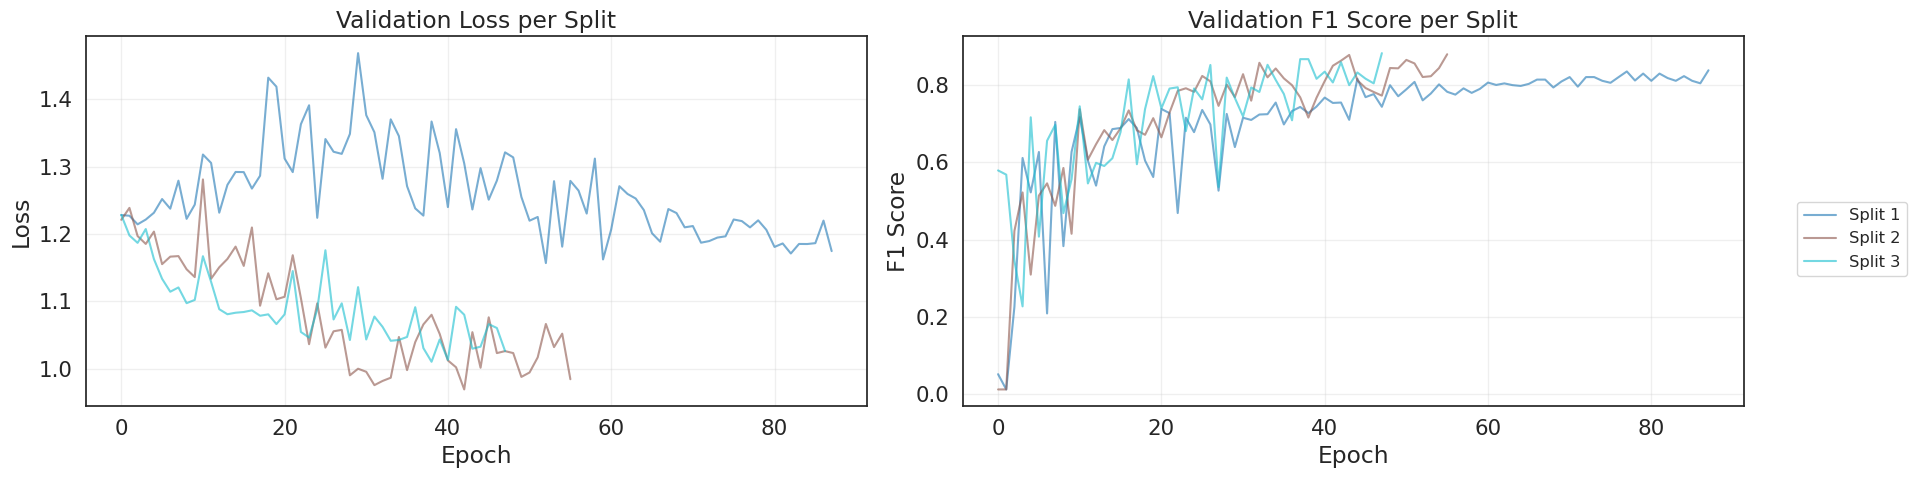

In [ ]:
# Create figure with two subplots sharing x axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharex=True)

# Color palette for K splits
colors = plt.cm.get_cmap('tab10', K)

# Plot validation loss for each split
for split in range(K):
    axes[0].plot(losses[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[0].set_title('Validation Loss per Split')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

# Plot validation F1 score for each split
for split in range(K):
    axes[1].plot(metrics[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[1].set_title('Validation F1 Score per Split')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

# Add shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.975)
plt.show()

---
## 🚀 **Try to reduce model capacity and add slight regularization...**
> ...

In [ ]:
# Cross-validation
K = 5                    # Number of splits (5 and 10 are considered good values)
VAL_SIZE = 99            # Size or fraction for validation splits

# Training
EPOCHS = 10000           # Maximum epochs (increase to improve performance)
PATIENCE = 100           # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 64          # Batch size
WINDOW_SIZE = 160        # Input window size
STRIDE = 160             # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 64         # Neurons per layer
RNN_TYPE = 'GRU'         # Type of RNN architecture
BIDIRECTIONAL = True     # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.2       # Dropout probability
L1_LAMBDA = 0.           # L1 penalty
L2_LAMBDA = 1e-4         # L2 penalty

# Loss function
ALPHA = 0.1              # Smoothing applied on the loss (between 0 and 1)
CLASS_WEIGHTS_LIST = [0.43, 2.32, 4.0]
CLASS_WEIGHTS = torch.tensor(CLASS_WEIGHTS_LIST, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=ALPHA, weight=CLASS_WEIGHTS)


# Experiment name
base_experiment_name = f'{str(datetime.now())}_gru_v2_less-capacity_slight-regularization'


# Initialize best model tracking variables
best_model = None
best_experiment_name = None
best_performance = float('-inf')

In [ ]:
%%time
# Execute K-fold cross-validation with baseline configuration
losses, metrics, best_scores, best_model, best_experiment_name = k_shuffle_split_cross_validation_round_rnn(
    df=df_features,
    df_labels=df_labels,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name=base_experiment_name,
    test_size=VAL_SIZE,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL
)

final_best_params = {
  'k': K,
  'test_size': VAL_SIZE,
  'epochs': EPOCHS,
  'patience': PATIENCE,
  'verbose': 0,
  'learning_rate': LEARNING_RATE,
  'batch_size': BATCH_SIZE,
  'window_size': WINDOW_SIZE,
  'stride': STRIDE,
  'hidden_layers': HIDDEN_LAYERS,
  'hidden_size': HIDDEN_SIZE,
  'rnn_type': RNN_TYPE,
  'bidirectional': BIDIRECTIONAL,
  'dropout_rate': DROPOUT_RATE,
  'l1_lambda': L1_LAMBDA,
  'l2_lambda': L2_LAMBDA,
  'criterion': criterion,
  'device': device,
  'seed': SEED
}

Split 1/3
  Training set shape: (89920, 44)
  Validation set shape: (15840, 44)
  Training sequences shape: (562, 160, 42)
  Validation sequences shape: (99, 160, 42)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2254, F1 Score=0.0224 | Val: Loss=1.2281, F1 Score=0.0516
Epoch  10/10000 | Train: Loss=0.9852, F1 Score=0.6748 | Val: Loss=1.2436, F1 Score=0.6272
Epoch  20/10000 | Train: Loss=0.8898, F1 Score=0.7650 | Val: Loss=1.4188, F1 Score=0.5622
Epoch  30/10000 | Train: Loss=0.7342, F1 Score=0.8860 | Val: Loss=1.4686, F1 Score=0.6397
Epoch  40/10000 | Train: Loss=0.6368, F1 Score=0.9168 | Val: Loss=1.3201, F1 Score=0.7446
Epoch  50/10000 | Train: Loss=0.6207, F1 Score=0.9382 | Val: Loss=1.2550, F1 Score=0.7713
Epoch  60/10000 | Train: Loss=0.5838, F1 Score=0.9790 | Val: Loss=1.1621, F1 Score=0.7903
Epoch  70/10000 | Train: Loss=0.5574, F1 Score=0.9982 | Val: Loss=1.2099, F1 Score=0.8096
Epoch  80/10000 | Train: Loss=0.5524, F1 Score=1.0000 | Val: Loss=1.2062, F1 Score=0.830

Plot history

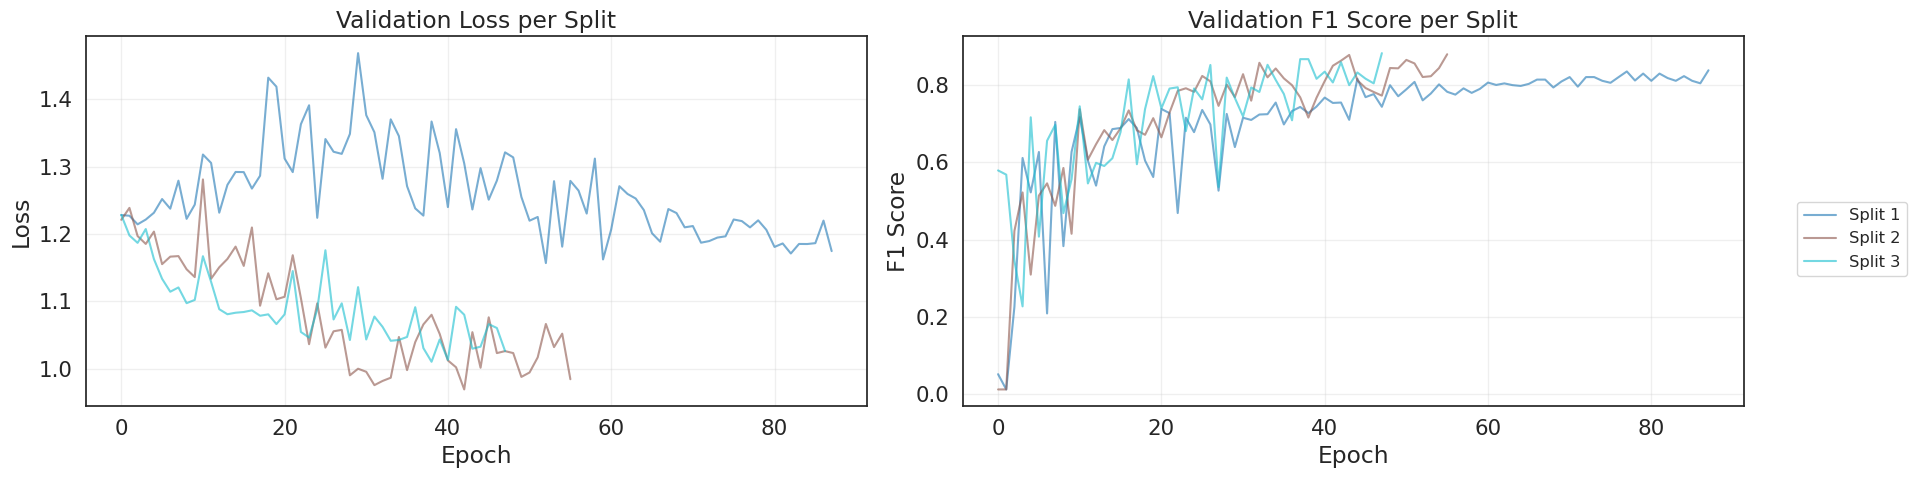

In [ ]:
# Create figure with two subplots sharing x axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharex=True)

# Color palette for K splits
colors = plt.cm.get_cmap('tab10', K)

# Plot validation loss for each split
for split in range(K):
    axes[0].plot(losses[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[0].set_title('Validation Loss per Split')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

# Plot validation F1 score for each split
for split in range(K):
    axes[1].plot(metrics[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[1].set_title('Validation F1 Score per Split')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

# Add shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.975)
plt.show()

---
## 🚀 **Run a baseline with K-Shuffle-Split!**



## **Baseline configuration**

In [ ]:
# Cross-validation
K = 10                   # Number of splits (5 and 10 are considered good values)
VAL_SIZE = 99            # Size or fraction for validation splits

# Training
EPOCHS = 10000           # Maximum epochs (increase to improve performance)
PATIENCE = 100           # Early stopping patience (increase to improve performance)
VERBOSE = 2              # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 64          # Batch size
WINDOW_SIZE = 80         # Input window size
STRIDE = 5               # Input stride

# Architecture
HIDDEN_LAYERS = 4        # Hidden layers
HIDDEN_SIZE = 64         # Neurons per layer
RNN_TYPE = 'GRU'         # Type of RNN architecture
BIDIRECTIONAL = True     # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Loss function
ALPHA = 0.1              # Smoothing applied on the loss (between 0 and 1)
CLASS_WEIGHTS_LIST = [1, 1.2, 1.4]
CLASS_WEIGHTS = torch.tensor(CLASS_WEIGHTS_LIST, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=ALPHA, weight=CLASS_WEIGHTS)


# Experiment name
base_experiment_name = f'{str(datetime.now())}_gru_baseline'


# Initialize best model tracking variables
best_model = None
best_experiment_name = None
best_performance = float('-inf')

In [ ]:
%%time
# Execute K-fold cross-validation with baseline configuration
losses, metrics, best_scores, best_model, best_experiment_name = k_shuffle_split_cross_validation_round_rnn(
    df=df_features,
    df_labels=df_labels,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name=base_experiment_name,
    test_size=VAL_SIZE,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL
)

final_best_params = {
  'k': K,
  'test_size': VAL_SIZE,
  'epochs': EPOCHS,
  'patience': PATIENCE,
  'verbose': 0,
  'learning_rate': LEARNING_RATE,
  'batch_size': BATCH_SIZE,
  'window_size': WINDOW_SIZE,
  'stride': STRIDE,
  'hidden_layers': HIDDEN_LAYERS,
  'hidden_size': HIDDEN_SIZE,
  'rnn_type': RNN_TYPE,
  'bidirectional': BIDIRECTIONAL,
  'dropout_rate': DROPOUT_RATE,
  'l1_lambda': L1_LAMBDA,
  'l2_lambda': L2_LAMBDA,
  'criterion': criterion,
  'device': device,
  'seed': SEED
}

Plot history

In [ ]:
# Create figure with two subplots sharing x axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharex=True)

# Color palette for K splits
colors = plt.cm.get_cmap('tab10', K)

# Plot validation loss for each split
for split in range(K):
    axes[0].plot(losses[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[0].set_title('Validation Loss per Split')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

# Plot validation F1 score for each split
for split in range(K):
    axes[1].plot(metrics[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[1].set_title('Validation F1 Score per Split')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

# Add shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.975)
plt.show()

---
## 🚀 **Run a grid search!**

In [ ]:
%%time
# Define parameters to search
param_grid = {
    'window_size': [50, 100, 200, 400],
    'stride': [25, 50],
}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'dropout_rate': DROPOUT_RATE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'rnn_type': RNN_TYPE,
    'bidirectional': BIDIRECTIONAL
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'test_size': VAL_SIZE,
    'patience': PATIENCE,
    'verbose': 0,
    'seed': SEED
}


# Execute search
results, best_config, best_score = grid_search_cv_rnn(
    df=df_features,
    df_labels=df_labels,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)

final_best_params = {**fixed_params, **best_config}
best_experiment_name = "_".join([f"{k}_{v}" for k, v in best_config.items()])

In [ ]:
# Visualise results
plot_top_configurations_rnn(results, k_splits=K, top_n=5)

## 🔮 **Inference!**

In [ ]:
# REQUIRED TO PROCEED:
# - final_best_params         with the whole model configuration
# - best_experiment_name      path to retrieve the model from


# ==============================================================================
#  RELOAD THE BEST MODEL AND ITS STATE
# ==============================================================================
# Rebuild an equivalent model
inference_model = RecurrentClassifier(
        input_size=len(pain_survey_ohenceded_cols) + len(joint_cols), # (34)
        num_classes=len(label_mapping), # (3)
        hidden_size=final_best_params['hidden_size'],
        num_layers=final_best_params['hidden_layers'],
        dropout_rate=final_best_params['dropout_rate'],
        bidirectional=final_best_params['bidirectional'],
        rnn_type=final_best_params['rnn_type']
    ).to(device)

# Reload the weights of the specified model
inference_model_path = f"models/{best_experiment_name}_model.pt"
inference_model.load_state_dict(torch.load(inference_model_path, map_location=device))
print(f"Model loaded successfully from '{best_experiment_name}' as inference model")



# TODO - RETRAIN ON WHOLE TRAINING DATA ??



# ==============================================================================
#  INFERENCE
# ==============================================================================
# Normalise features using training set statistics
whole_train_max = df_features[joint_cols].max()
whole_train_min = df_features[joint_cols].min()
df_test_inference = df_test.copy()
df_test_inference[joint_cols] = (df_test_inference[joint_cols] - whole_train_min) / (whole_train_max - whole_train_min + 1e-8)

# Prepare inputs for testing using the modified build_sequences function
X_test, test_sequence_sample_indices = build_sequences(
    df_features=df_test_inference,
    df_labels=None, # No labels for test data
    window=final_best_params['window_size'],
    stride=final_best_params['stride']
)
test_ds = TensorDataset(torch.from_numpy(X_test))
test_loader = make_loader(test_ds, batch_size=final_best_params['batch_size'], shuffle=False, drop_last=False)
print(f"Test dataset prepared to be fed into '{best_experiment_name}'")

# Start inference
print("Starting inference...")
inference_model.eval()
all_test_preds = []

with torch.no_grad():
    for (inputs,) in test_loader: # Note: (inputs,) because there's no 'y' !!!
        inputs = inputs.to(device)
        inputs = inputs.to(torch.float32)

        logits = inference_model(inputs)
        preds = logits.argmax(dim=1)

        all_test_preds.append(preds.cpu().numpy())

# Concatenate all predictions
all_test_preds = np.concatenate(all_test_preds)
# Create a DataFrame to associate predictions with original sample indices
predictions_df = pd.DataFrame({
    'sample_index': test_sequence_sample_indices,
    'prediction': all_test_preds
})
# Filter the predictions DataFrame to keep only the last prediction for each sample
last_sequence_indices = predictions_df.groupby('sample_index').tail(1).index
last_predictions_df = predictions_df.loc[last_sequence_indices]
# Sort by sample_index to ensure consistent order with original test sample indices
last_predictions_df = last_predictions_df.sort_values(by='sample_index').reset_index(drop=True)



# ==============================================================================
#  SUBMISSION PREPARATION AND DUMP
# ==============================================================================
# Inverse labels mapping from integer encoding to string
inv_label_mapping = {v: k for k, v in label_mapping.items()}
test_predictions_labels = [inv_label_mapping[pred] for pred in last_predictions_df['prediction']]

# Create the submission DataFrame
df_submission = pd.DataFrame({
    'sample_index': last_predictions_df['sample_index'], # Use sample indices from the filtered predictions
    'label': test_predictions_labels
})

# Save submission DataFrame into a CSV file
submission_dir = f'submissions/{best_experiment_name}'
os.makedirs(submission_dir, exist_ok=True)
submission_filename = f'{str(datetime.now())}.csv'
submission_path = os.path.join(submission_dir, submission_filename)
df_submission.to_csv(submission_path, index=False)
print(f"\nSaved submission for {best_experiment_name} into: {submission_path}")

print(f"\nSubmission inspection:")
print(df_submission.shape)
display(df_submission.head())

Model loaded successfully from '20251109_0300_gru_baseline/split_9' as inference model
Test dataset prepared to be fed into '20251109_0300_gru_baseline/split_9'
Starting inference...

Saved submission for 20251109_0300_gru_baseline/split_9 into: submissions/20251109_0300_gru_baseline/split_9/2025-11-09 13:33:08.297557.csv

Submission inspection:
(1324, 2)


,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,no_pain
3,3,no_pain
4,4,no_pain


### 🚨🚨🚨 **BE CAREFUL WHEN LAUNCHING THIS** 🚨🚨🚨

In [ ]:
def clean_models_directory(scores, best_configuration):
    """
    Deletes all model directories and files in the 'models' directory
    except for the directory containing the best model based on the
    best_configuration.

    Args:
        scores (dict): Dictionary containing the results of the hyperparameter search.
        best_configuration (dict): Dictionary containing the hyperparameters
                                   of the best performing configuration.
    """
    models_dir = "models"
    if not os.path.exists(models_dir):
        print(f"Models directory '{models_dir}' not found.")
        return

    # Construct the expected directory name for the best configuration
    best_config_dir_name = f"bs_{best_configuration['batch_size']}_lr_{best_configuration['learning_rate']}_hl_{best_configuration['hidden_layers']}_hs_{best_configuration['hidden_size']}_dr_{best_configuration['dropout_rate']}_l1_{best_configuration['l1_lambda']}_l2_{best_configuration['l2_lambda']}"
    best_config_path = os.path.join(models_dir, best_config_dir_name)

    # Add a check to ensure the best configuration directory exists
    if not os.path.exists(best_config_path):
        print(f"Error: Best model directory '{best_config_path}' not found. Cannot clean directory safely.")
        return

    print(f"Keeping the best model directory: {best_config_path}")

    # Iterate through all items in the models directory
    for item in os.listdir(models_dir):
        item_path = os.path.join(models_dir, item)

        # If the item is a file or a directory and not the best configuration directory, delete it
        if item_path != best_config_path:
            if os.path.isdir(item_path):
                print(f"Deleting directory: {item_path}")
                shutil.rmtree(item_path)
            elif os.path.isfile(item_path):
                print(f"Deleting file: {item_path}")
                os.remove(item_path)

    print("Models directory cleaned.")

# clean_models_directory(scores, best_configuration)

In [ ]:
# Zip the contents of the /kaggle/working directory
!zip -r /kaggle/working/20251109-gru-training.zip /kaggle/working/*